In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from helpers import load_config

In [139]:
PREFIX = "/mnt/c/Users/scl38887/Documents/git/pypsa-nz/"
tech_colors = PREFIX + "config/tech_colors.yaml"

In [140]:
colors = load_config(tech_colors)    

In [141]:
country = "DEU"
kickoff_year = 2023

### Read and prepare RE production data

In [142]:
# Read data https://ourworldindata.org/renewable-energy
re_prod = pd.read_csv('../../data/owid/modern-renewable-prod.csv')

In [143]:
re_prod = re_prod[re_prod.Code == country]
re_prod = re_prod.dropna(subset=['Code'])
re_prod = re_prod.set_index('Year')
re_prod = re_prod.sort_index()
re_prod = re_prod.dropna(subset=['Code'])
re_prod = re_prod.rename(columns={'Electricity from wind - TWh': 'wind',
                                  'Electricity from solar - TWh': 'solar',
                                  "Electricity from hydro - TWh": "hydro",
                                  "Other renewables including bioenergy - TWh": "others",})

### Read and prepare demand data

In [144]:
edemand = pd.read_csv('../../data/owid/electricity-demand.csv')

In [145]:
edemand = edemand[edemand.Year == kickoff_year]
edemand = edemand[edemand.Code == country]
# Drop rows where Code is NaN
edemand = edemand.dropna(subset=['Code'])
edemand = edemand.rename(columns={'Electricity demand - TWh': 'edemand'})

In [146]:
edemand.edemand.values[0]

44.52

### Add Growth

In [147]:
techs = ["wind", "solar"]
growth = {"solar": [0.6,1.7],
     "wind": [0.8,1.4]} # in %, obtained from 10.1038/s41560-021-00863-0
#g_solar = 10 # in %
demand=edemand.edemand.values[0] # Demand at takeoff year
years=np.array(range(re_prod.index[-1],2050+1,1))
new_supply = pd.DataFrame(index=years)

for tech in techs:
     floor=re_prod[tech].iloc[-1] # Solar/wind production at takeoff year

     for g in growth[tech]:
          new_supply_tech = g/100 * demand * (years-re_prod.index[-1]) + floor
          new_supply[tech+str(g)] = new_supply_tech

### Plot

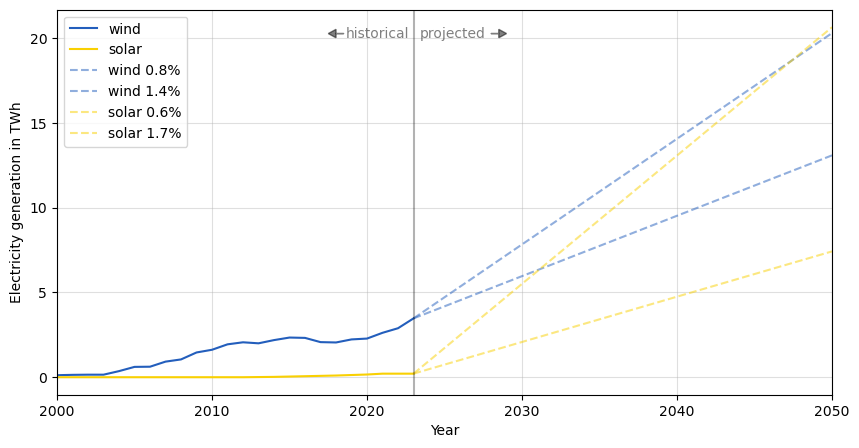

In [187]:
# Set up figure
fig = plt.figure(facecolor='white', figsize=(10, 5))

ax = fig.add_subplot(1,1,1)

ax.plot("wind", data=re_prod, color=colors["tech_colors"]["onshore wind"], label="wind")
ax.plot("solar", data=re_prod, color=colors["tech_colors"]["solar PV"], label="solar")

# Add growth
for tech in techs:
     for g in growth[tech]:
          ax.plot(new_supply.index, new_supply[tech+str(g)], color=colors["tech_colors"][tech], alpha=0.5, linestyle="--", label=f"{tech} {g}%")

# Add vertical line at 2035


# Add historical/projected RE feed in
height = 20
ax.axvline(x=re_prod.index[-1], color='black', alpha=0.3)
plt.text(re_prod.index[-1]+0.4, height, 'projected', color='black', alpha=0.5)
plt.text(re_prod.index[-1]-4.4, height, 'historical', color='black', alpha=0.5)
plt.arrow(re_prod.index[-1]+5, height+0.27, 0.5, 0, head_width=0.5, head_length=0.5, fc='black', ec='black', alpha=0.5,)
plt.arrow(re_prod.index[-1]-4.5, height+0.27, -0.5, 0, head_width=0.5, head_length=0.5, fc='black', ec='black', alpha=0.5)

# Limit the plot
ax.set_xlim(2000, 2050)
# ax.set_ylim(0,100)

# Further elements
ax.set_ylabel("Electricity generation in TWh")
ax.set_xlabel("Year")
plt.grid(alpha=0.4)
plt.legend()

# Create graph and save it
#fig.savefig(snakemake.output.reshares, bbox_inches="tight")

plt.show()